In [16]:
import torchvision.models as models
from torchvision import transforms
import pandas as pd
from PIL import Image
import torch
from sklearn.linear_model import Ridge, Lasso
import numpy as np
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.util import img_as_float
from skimage import io

resnet18 = models.resnet18(pretrained=True)

/Users/loten.noy/.local/share/virtualenvs/Advanced-Machine-Learning-3945-j80Fnnv0/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/loten.noy/.local/share/virtualenvs/Advanced-Machine-Learning-3945-j80Fnnv0/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
class Resnet:
    def __init__(self):
        self.model = resnet18
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )])
        classes = pd.read_csv('data/imagenet_classes.csv', header=None)
        self.labels = list(classes.iloc[:, 1].str.strip())

    def predict_k(self, img, k=3, show_img=False):
        img = Image.fromarray((img * 255).astype(np.uint8))
        img_t = self.transform(img)

        if show_img:
            self.imageshow(img_t)

        batch_t = torch.unsqueeze(img_t, 0)
        out = resnet18(batch_t)
        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        _, indices = torch.sort(out, descending=True)
        return [(idx, self.labels[idx], percentage[idx].item()) for idx in indices[0][:k]]

    @staticmethod
    def imageshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        _, ax = plt.subplots(1, 1, figsize=(20, 10))
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [25]:
class Lime:
    def __init__(self, n_segments=50, n_samples=100, p_samples=0.8):
        self.n_segments = n_segments
        self.n_samples = n_samples
        self.p_samples = p_samples
        self.lasso = None

    def _plot_segments(self, image, segments, predictions, image_path):
        _, ax = plt.subplots(1, 1, figsize=(20, 10))
        ax.imshow(mark_boundaries(image, segments))
        plt.title(f"{image_path} segmentation\ntop 3 predictions: {predictions}")
        plt.axis("off")
        # show the plots
        plt.show()

    def _get_feature_imporatnce(self, X, y):
        self.lasso = Lasso()
        w = np.linalg.norm(np.ones(X.shape[1]) - X, axis=1) ** 2
        self.lasso.fit(X, y, sample_weight=w)
        features_importance = np.argsort(np.abs(self.lasso.coef_))[::-1]
        return features_importance

    def _get_labels(self, X_images, estimator, predictions):
        y = np.array([estimator.predict_k(sample, k=1)[0][0] for sample in X_images])
        for i in range(len(y)):
            if y[i] not in (pred[0] for pred in predictions):
                y[i] = 0
        return y

    def _generate_random_samples(self, image, segments):
        X = np.random.binomial(1, p=self.p_samples, size=(self.n_samples, np.unique(segments).shape[0]))
        X_images = []
        for x in range(X.shape[0]):
            new_img_seg = segments.copy()
            for col in range(X.shape[1]):
                if not X[x, col]:
                    new_img_seg -= new_img_seg * (new_img_seg == col + 1)

            new_img_seg[new_img_seg != 0] = 1
            new_img = image.copy()
            new_img *= new_img_seg[:, :, None]
            X_images.append(new_img)
        return X, X_images

    @staticmethod
    def plot_k_most_sig_features(image, segments, features_importance, k):
        new_img_seg = segments.copy()
        for col in features_importance[k:]:
            new_img_seg -= new_img_seg * (new_img_seg == col + 1)

        new_img_seg[new_img_seg != 0] = 1
        new_img = image.copy()
        new_img *= new_img_seg[:, :, None]

        _, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax.set(title=f'{k} most significant segments for prediction')
        ax.imshow(new_img)
    
    def explain(self, estimator, image_path, k=10):
        image = img_as_float(io.imread(image_path))
        predictions = estimator.predict_k(image, 3)
        
        # apply SLIC and extract (approximately) the supplied number of segments
        segments = slic(image, n_segments=self.n_segments, sigma=5)
        self._plot_segments(image, segments, predictions, image_path)
        
        # generate random samples
        X, X_images = self._generate_random_samples(image, segments)
        y = self._get_labels(X_images, estimator, predictions)

        # fit ridge regression model and plot k most significant segments
        features_importance = self._get_feature_imporatnce(X, y)
        self.plot_k_most_sig_features(image, segments, features_importance, k)

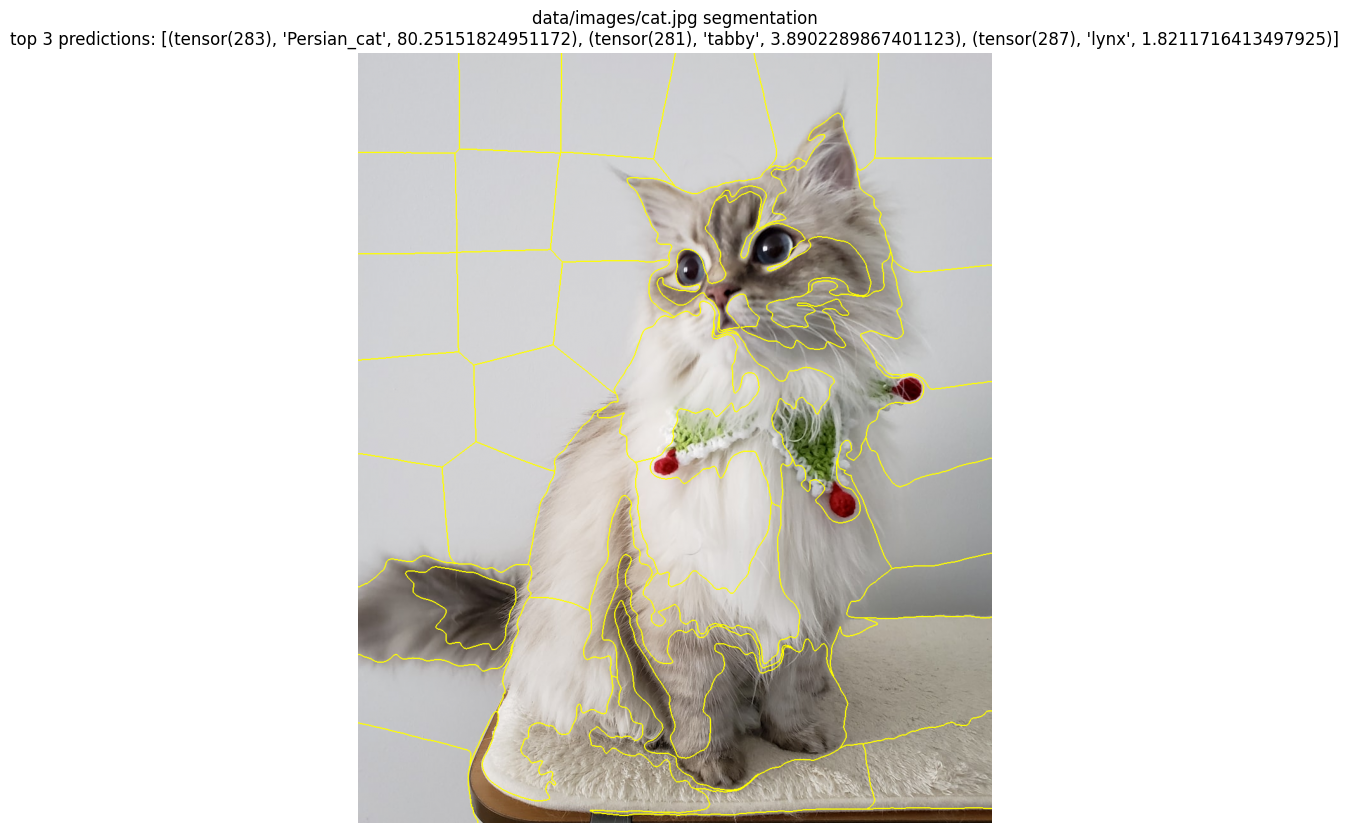

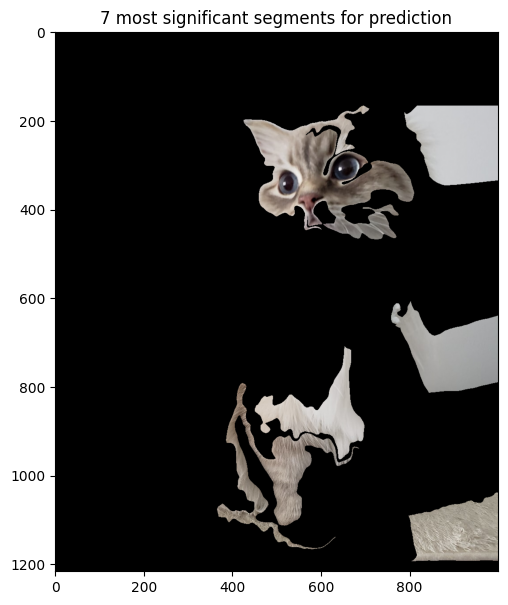

In [26]:
lime = Lime()
lime.explain(Resnet(), 'data/images/cat.jpg', k=7)

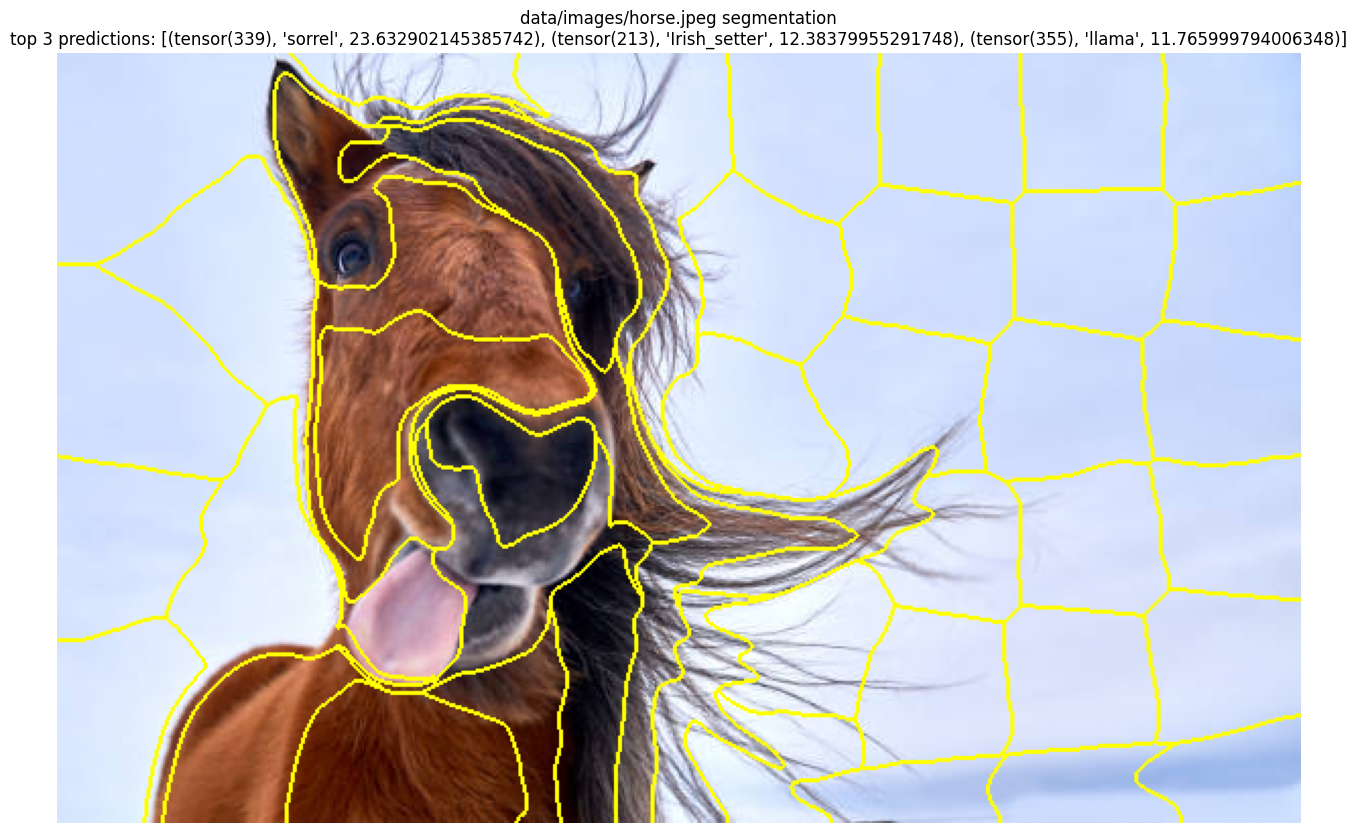

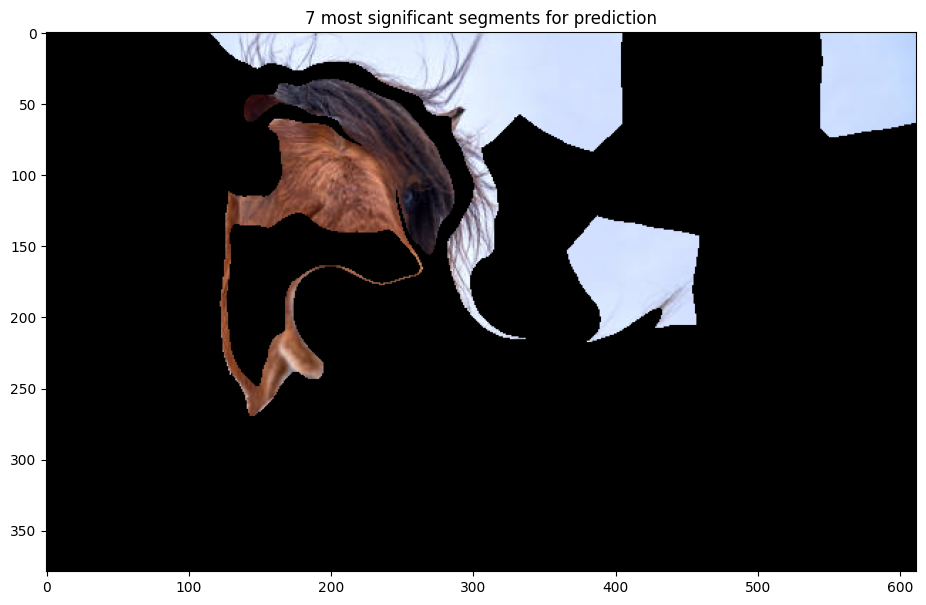

In [27]:
lime.explain(Resnet(), 'data/images/horse.jpeg', k=7)

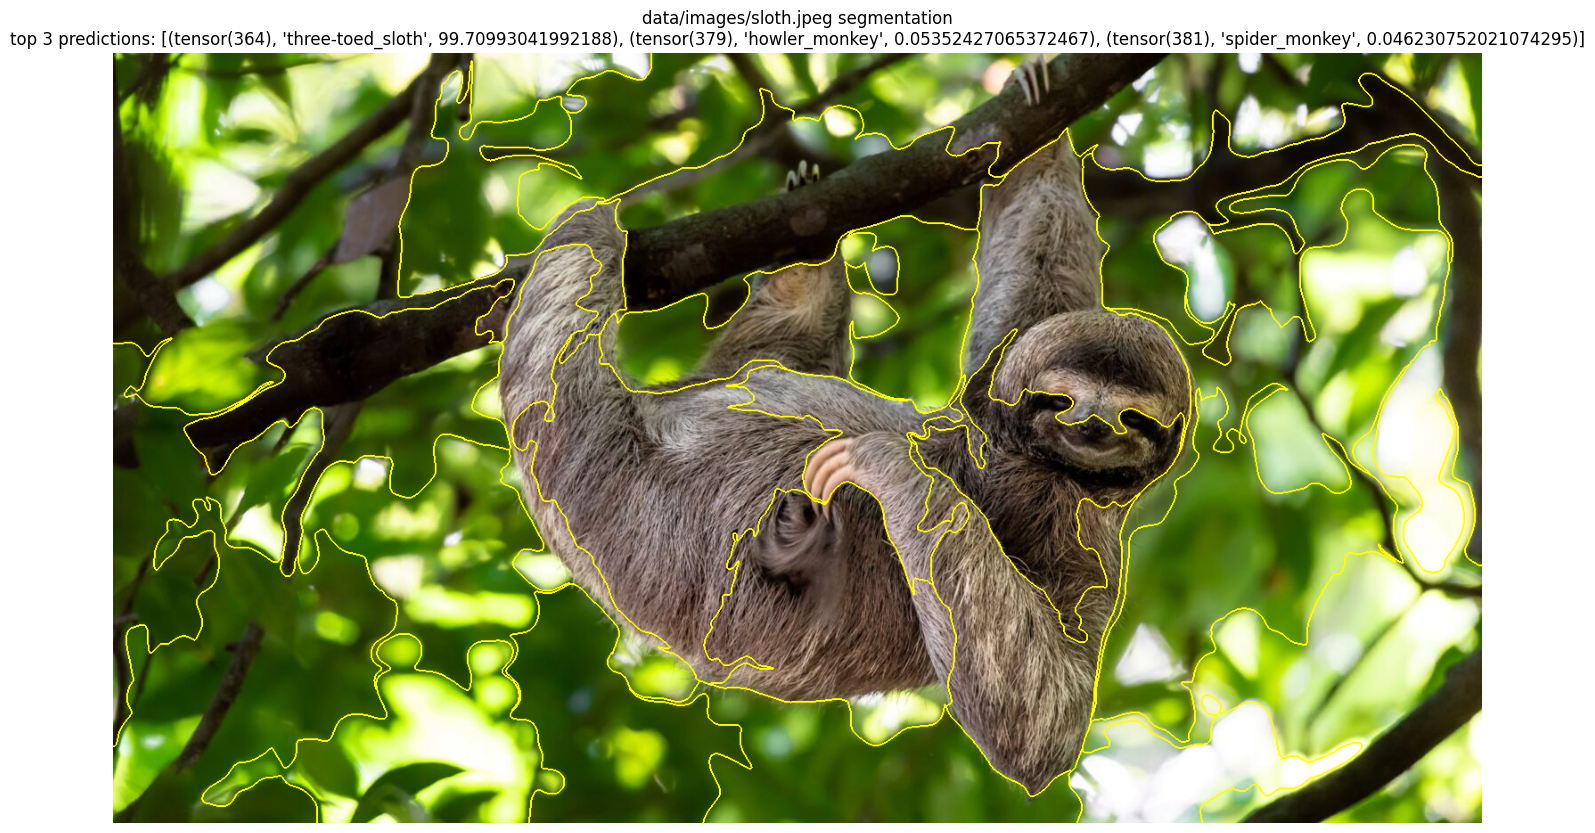

/Users/loten.noy/.local/share/virtualenvs/Advanced-Machine-Learning-3945-j80Fnnv0/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


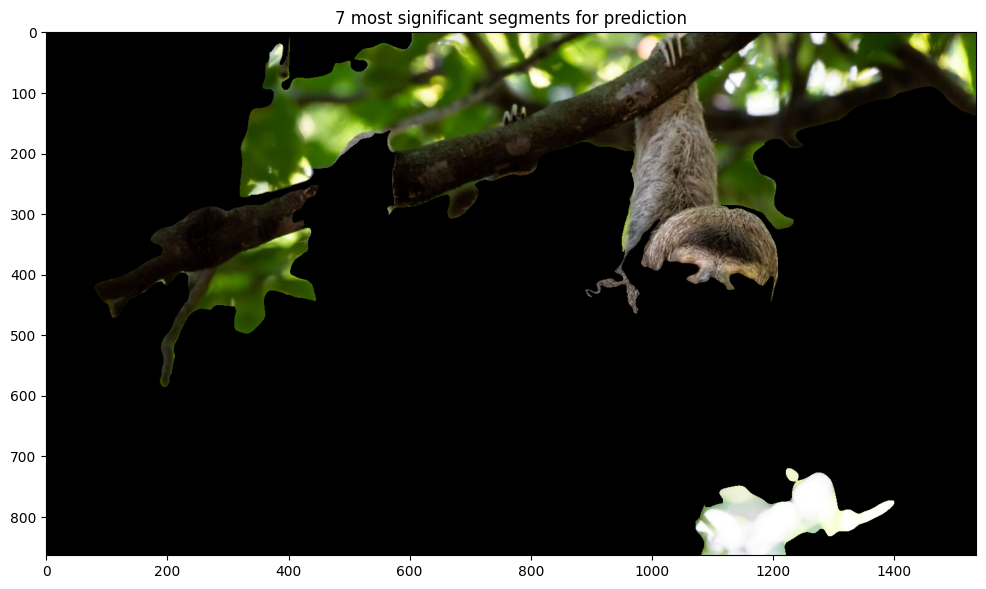

In [29]:
lime.explain(Resnet(), 'data/images/sloth.jpeg', k=7)